In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from tensorflow import keras
from tensorflow.keras import layers

colors = ["#9DAFB0", "#75E6DA", '#189AB4', '#05445E', '#4D707E', '#56B66B']


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv


# Introduction


Stroke is a condition that occurs when the blood supply to the brain decreases due to a blockage (ischemic stroke) or rupture of a blood vessel (hemorrhagic stroke). Without blood, the brain will not get oxygen and nutrients, so the cells in the affected brain area will soon die. 

According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.

Stroke is a medical emergency because brain cells can die in just a matter of minutes. The death of brain cells causes the parts of the body that are controlled by the damaged areas of the brain to not function properly. Prompt treatment can minimize the level of damage to the brain and the possibility of complications. 


From the description above, we know that stroke is simply deadly. In this notebook im trying to found out can we predict the possibility of a patient having a stroke based on the given dataset.

## Attribute Information

* id: unique identifier
* gender: "Male", "Female" or "Other"
* age: age of the patient
* hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
* heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
* ever_married: "No" or "Yes"
* work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
* Residence_type: "Rural" or "Urban"
* avg_glucose_level: average glucose level in blood
* bmi: body mass index
* smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
* stroke: 1 if the patient had a stroke or 0 if not
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient


# Loading Data

In [2]:
data = pd.read_csv("/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv")
data.drop(['id'], axis=1, inplace=True)
data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [3]:
feature_num = ['age', 'avg_glucose_level', 'bmi']
feature_cat = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
label = ['stroke']

In [4]:
data.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

# EDA

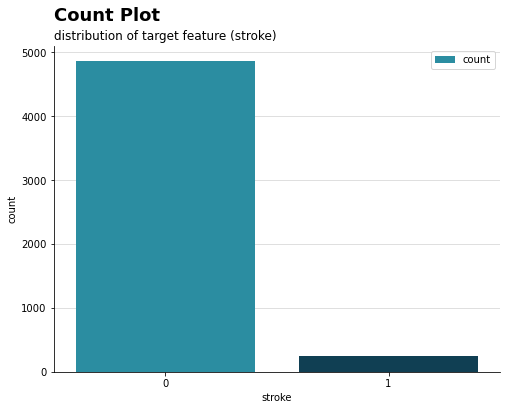

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.countplot(data=data, x='stroke', ax=ax, palette=colors[2:4])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_axisbelow(True)


plt.legend(['count'])
plt.grid(axis='y', alpha=0.5)
plt.suptitle("Count Plot", ha='left', x=0.125, y=0.97, fontsize=18, fontweight='bold')
plt.title("distribution of target feature (stroke)", loc='left')
plt.show()

the dataset is highly imbalance, we will try to oversample the dataset using SMOTE later on

In [6]:
data = data[data.gender != 'Other']

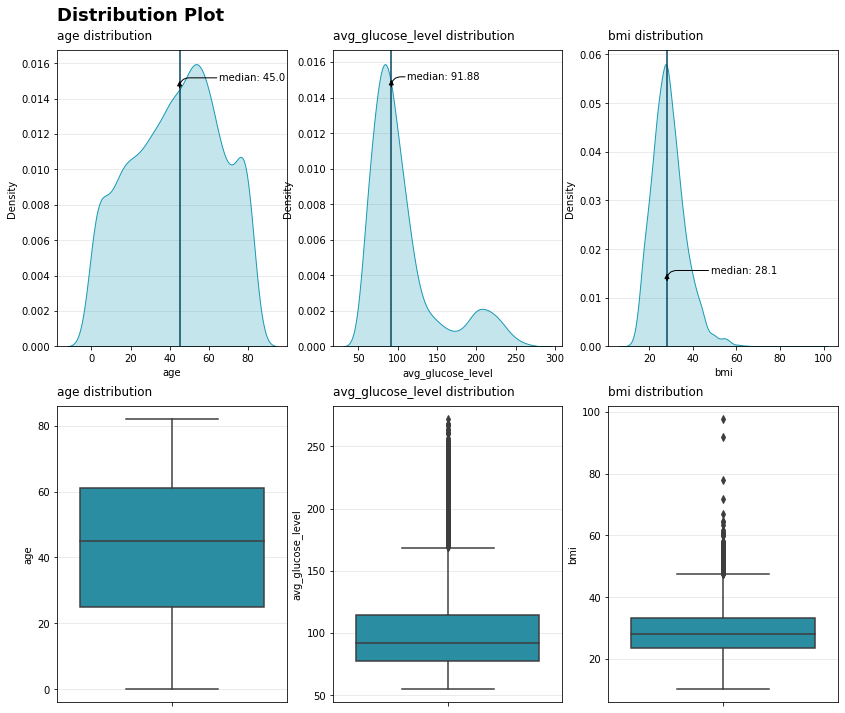

In [7]:
df = data[feature_num]

fig, ax = plt.subplots(2, 3, figsize=(14, 12))

for i in range(3) : 
    median = df.median()[feature_num[i]]
    sns.kdeplot(data=df, x=feature_num[i], ax=ax[0, i], shade=True, color=colors[2])
    ax[0, i].axvline(x=median, color='#05445E')

    ax[0, i].set_title(f'{feature_num[i]} distribution', loc='left', pad=10)
    ax[0, i].grid(axis='y', alpha=0.3)
    ax[0, i].annotate(
        f'median: {median}', 
        xy=(median, 0.015), 
        xytext=(median+20, 0.015), 
        arrowprops=dict(arrowstyle='-|>',
        fc='black', shrinkA=0, shrinkB=0,            
        connectionstyle='angle,angleA=0,angleB=90,rad=10')
    )

    ax[0, i].set_axisbelow(True)


for i in range(3) : 
    median = df.median()[feature_num[i]]
    sns.boxplot(data=df, y=feature_num[i], ax=ax[1, i], color=colors[2])
    ax[1, i].set_title(f'{feature_num[i]} distribution', loc='left', pad=10)
    ax[1, i].grid(axis='y', alpha=0.3)
    ax[1, i].set_axisbelow(True)
  
plt.suptitle("Distribution Plot", ha='left', x=0.125, y=0.93, fontsize=18, fontweight='bold')
plt.show()

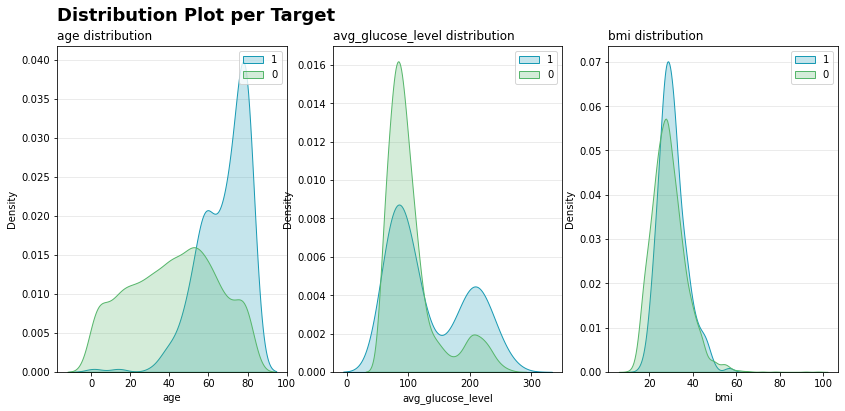

In [8]:
df1 = data[data.stroke == 1]
df0 = data[data.stroke == 0]


fig, ax = plt.subplots(1, 3, figsize=(14, 6))
for i in range(3) : 
    sns.kdeplot(data=df1, x=feature_num[i], ax=ax[i], shade=True, color=colors[2])
    sns.kdeplot(data=df0, x=feature_num[i], ax=ax[i], shade=True, color=colors[5])

    ax[i].set_title(f'{feature_num[i]} distribution', loc='left')
    ax[i].legend(['1', '0'])
    ax[i].grid(axis='y', alpha=0.3)
    ax[i].set_axisbelow(True)

plt.suptitle("Distribution Plot per Target", ha='left', x=0.125, y=0.97, fontsize=18, fontweight='bold')
plt.show()

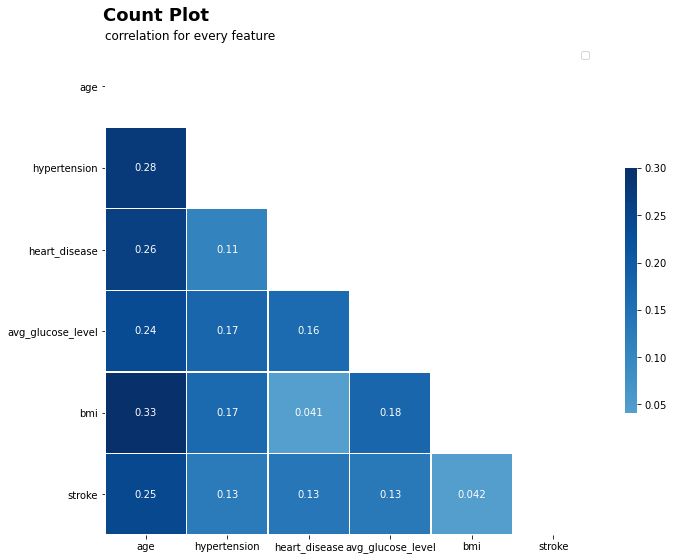

In [9]:
df = data
corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(11, 9))

mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))

sns.heatmap(corr, mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, cmap=sns.color_palette("Blues", as_cmap=True))

ax.set_axisbelow(True)

plt.legend(['Pearson Correlation'])
plt.suptitle("Count Plot", ha='left', x=0.125, y=0.94, fontsize=18, fontweight='bold')
plt.title("correlation for every feature", loc='left')
plt.show()

# Handle Missing Data

In [10]:
data.groupby('ever_married').mean()[['bmi']]

,bmi
ever_married,
No,25.216373
Yes,30.850749


In [11]:
data['bmi'] = data.groupby('ever_married').transform(lambda x: x.fillna(x.mean()))['bmi']
data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,30.850749,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,30.850749,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.000000,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.600000,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.600000,formerly smoked,0


In [12]:
X = data.drop(['stroke'], axis=1)
y = data['stroke']

# Pre-processing

In [13]:
transformer_num = make_pipeline(MinMaxScaler())
transformer_cat = make_pipeline(OneHotEncoder())

preprocessor = make_column_transformer(
    (transformer_num, feature_num),
    (transformer_cat, feature_cat),
)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, train_size=0.8)
X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[-1]]

# SMOTE

I apply smote only on train set to avoid data leakage

In [14]:
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

# Modelling

## Random Forest

In [15]:
clf_rand = RandomForestClassifier(n_estimators=100)

clf_rand.fit(X_train, y_train) 

pred_rand= clf_rand.predict(X_valid)

print(classification_report(pred_rand, y_valid.to_numpy()))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       958
           1       0.18      0.14      0.16        64

    accuracy                           0.91      1022
   macro avg       0.56      0.55      0.55      1022
weighted avg       0.90      0.91      0.90      1022



## Naive Bayes

In [16]:
clf_nb = GaussianNB()

clf_nb.fit(X_train, y_train) 

pred_nb = clf_nb.predict(X_valid)

print(classification_report(pred_nb, y_valid.to_numpy()))

              precision    recall  f1-score   support

           0       0.34      1.00      0.51       336
           1       0.98      0.07      0.13       686

    accuracy                           0.38      1022
   macro avg       0.66      0.53      0.32      1022
weighted avg       0.77      0.38      0.26      1022



## Deep Learning

In [17]:
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    
    layers.Dense(units=128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(units=128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(units=128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(units=1, activation='sigmoid'),
    
])

In [18]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

In [19]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True
)

history = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_valid, y_valid),
    batch_size=32,
    epochs=200,
    callbacks=[early_stopping]
    
)

Epoch 1/200
243/243 [==============================] - 3s 6ms/step - loss: 0.7564 - binary_accuracy: 0.6308 - val_loss: 0.7226 - val_binary_accuracy: 0.5352
Epoch 2/200
243/243 [==============================] - 1s 4ms/step - loss: 0.5143 - binary_accuracy: 0.7567 - val_loss: 0.5485 - val_binary_accuracy: 0.6840
Epoch 3/200
243/243 [==============================] - 1s 4ms/step - loss: 0.4884 - binary_accuracy: 0.7728 - val_loss: 0.5069 - val_binary_accuracy: 0.7016
Epoch 4/200
243/243 [==============================] - 1s 3ms/step - loss: 0.4572 - binary_accuracy: 0.7904 - val_loss: 0.5186 - val_binary_accuracy: 0.6977
Epoch 5/200
243/243 [==============================] - 1s 3ms/step - loss: 0.4443 - binary_accuracy: 0.7957 - val_loss: 0.5096 - val_binary_accuracy: 0.7162
Epoch 6/200
243/243 [==============================] - 1s 3ms/step - loss: 0.4213 - binary_accuracy: 0.8081 - val_loss: 0.4687 - val_binary_accuracy: 0.7368
Epoch 7/200
243/243 [==============================] - 1s 

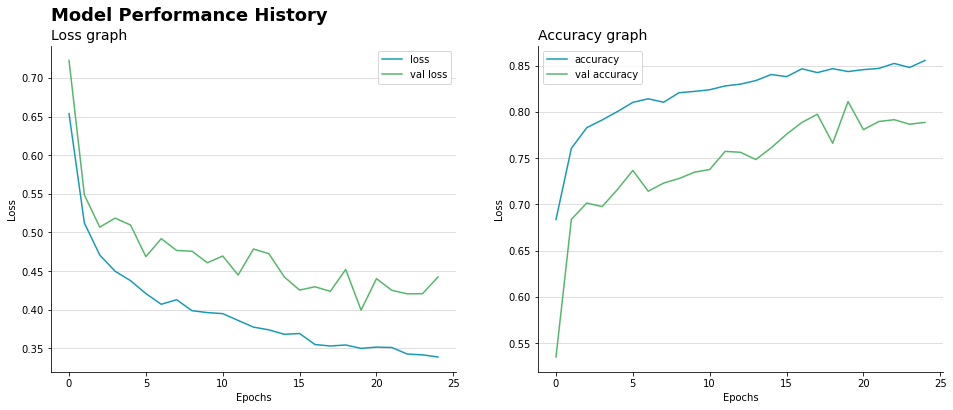

In [20]:
fig, ax = plt.subplots(1, 2,figsize=(16,6))

ax[0].plot(history.history['loss'], color=colors[2])
ax[0].plot(history.history['val_loss'], color=colors[5])
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_axisbelow(True)
ax[0].legend(["loss", "val loss"])
ax[0].grid(axis='y', alpha=0.5)
ax[0].set_title("Loss graph", loc='left', fontsize=14)
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epochs")

ax[1].plot(history.history['binary_accuracy'], color=colors[2])
ax[1].plot(history.history['val_binary_accuracy'], color=colors[5])
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_axisbelow(True)
ax[1].legend(["accuracy", "val accuracy"])
ax[1].set_title("Accuracy graph", loc='left', fontsize=14)
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("Epochs")



plt.grid(axis='y', alpha=0.5)
plt.suptitle("Model Performance History", ha='left', x=0.125, y=0.97, fontsize=18, fontweight='bold')
plt.show()

In [21]:
y_pred = model.predict(X_valid)
y_pred = [1 if i > 0.5 else 0 for i in y_pred]

In [22]:
print(classification_report(y_pred, y_valid.to_numpy()))

              precision    recall  f1-score   support

           0       0.82      0.98      0.89       817
           1       0.62      0.15      0.24       205

    accuracy                           0.81      1022
   macro avg       0.72      0.56      0.57      1022
weighted avg       0.78      0.81      0.76      1022



# Conclusion

since the data is highly imbalance and not enough feature that is given, our model aren't able to predict target 1 (person has stroke) in a high accuracy even though upsampling using SMOTE is already used on our dataset. 

given the right amount of dataset and feature, performance of the model might improve. 

### Side Note

if you have any feedback or criticism, please feel free to comments cheers!